# Attractors, stability, continuation

This lecture introduces the Attractors.jl library package of DynamicalSystems.jl,
which offers functionality for finding attractors of dynamical systems, studying global (non-local) stability, and performing continuation, among other things.

In [42]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.status(["DynamicalSystems", "Attractors", "CairoMakie", "OrdinaryDiffEq"]; mode = Pkg.PKGMODE_MANIFEST)

  Activating 

Status `C:\Users\gd419\OneDrive - University of Exeter\Teaching\NonlinearDynamicsComplexSystemsCourses\Manifest.toml`
  [f3fd9213] Attractors v1.13.0
  [13f3f980] CairoMakie v0.10.11
  [61744808] DynamicalSystems v3.2.2
  [1dea7af3] OrdinaryDiffEq v6.58.0


project at `c:\Users\gd419\OneDrive - University of Exeter\Teaching\NonlinearDynamicsComplexSystemsCourses`


In [43]:
VERSION # the Julia version

v"1.9.1"

In [44]:
using CairoMakie
update_theme!(resolution = (500, 300), fontsize = 16)

In [45]:
# Let's read the overview of Attractors.jl
using DynamicalSystems
@doc Attractors

# Attractors.jl

[![](https://img.shields.io/badge/docs-dev-lightblue.svg)](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/attractors/dev/) [![](https://img.shields.io/badge/docs-stable-blue.svg)](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/attractors/stable/) [![Paper](https://img.shields.io/badge/Cite-DOI:10.1063/5.0159675-purple)](https://arxiv.org/abs/2304.12786) [![CI](https://github.com/JuliaDynamics/Attractors.jl/workflows/CI/badge.svg)](https://github.com/JuliaDynamics/Attractors.jl/actions?query=workflow%3ACI) [![codecov](https://codecov.io/gh/JuliaDynamics/Attractors.jl/branch/main/graph/badge.svg)](https://codecov.io/gh/JuliaDynamics/Attractors.jl) [![Package Downloads](https://shields.io/endpoint?url=https://pkgs.genieframework.com/api/v1/badge/Attractors)](https://pkgs.genieframework.com?packages=Attractors)

A Julia module for

  * finding attractors of arbitrary dynamical systems
  * finding their basins of attraction or the state space fractions of the basins
  * analyzing global stability of attractors (also called non-local stability or  resilience)
  * "continuing" the attractors and their basins over a parameter range
  * finding the basin boundaries and analyzing their fractal properties
  * tipping points related functionality for systems with known dynamic rule
  * and more!

It can be used as a standalone package, or as part of [DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/dynamicalsystems/stable/).

To install it, run `import Pkg; Pkg.add("Attractors")`.

All further information is provided in the documentation, which you can either find [online](https://juliadynamics.github.io/DynamicalSystemsDocs.jl/attractors/stable/) or build locally by running the `docs/make.jl` file.

*Previously, Attractors.jl was part of ChaosTools.jl*


# Finding attractors and their basins

The bulk of the work in Attractors.jl is done by subtypes of `AttractorMapper`. Each subtype references a `DynamicalSystem`, and encapsulates an algorithm that allows to map initial conditions of the dynamical system into attractors. 
These `AttractorMapper`s compose an _extendable interface_.

The concrete subtypes that we'll cover here are:

1. `AttractorsViaRecurrences` 
2. `AttractorsViaFeaturizing`

## `AttractorsViaRecurrences`
Let's start with the recurrences algorithm. It implements the algorithm described in [Datseris & Wagemakers (2022), _Effortless estimation of basins of attraction_](https://doi.org/10.1063/5.0076568). Understanding of the algorithm is useful for deciding the keyword arguments of `AttractorsViaRecurrences`, however, explaining this algorithm in detail is not a part of this lecture due to time constraints! Worry not however, the exercises have been designed to work well with the default keywords!

The very short description is that, for "simple" dynamical systems like `CoupledODEs` or `DeterministicIteratedMap`, the Poincare recurrence theorem applies: it says that as the system state evolves on an attractor, it is guaranteed to visit a state space region it has already visited before. This is called a **recurrence**. The `AttractorsViaRecurrences` utilizes this fact to find attractors by tesselating a finite region of the state space into finite-sized cells, and coungint cells that have re-visited.

Here's a visual explanation:

<video width="50%" height="auto" controls autoplay loop>
<source src="https://raw.githubusercontent.com/JuliaDynamics/JuliaDynamics/master/videos/attractors/recurrence_algorithm.mp4?raw=true" type="video/mp4">
</video>

The only thing the algorithm needs is:

1. A dynamical system instance
2. A grid that both decides the state space region of interest as well as defines its tesselation

Remaining options are meta-parameters that tune the system behavior. Most cases work fine with default parameters so we won't be spending too much time on that...

We'll use `AttractorsViaRecurrences` to find attractors of the following dynamical system:
$$
\begin{aligned}
\dot{x} &= \sin(y) - bx\\
\dot{y} &= \sin(z) - by\\
\dot{z} &= \sin(x) - bz
\end{aligned}
$$
which is also called ["Thomas' cyclical system"](https://en.wikipedia.org/wiki/Thomas%27_cyclically_symmetric_attractor). Due to the symmetry of the equations of motion, any attractor has three symmetric versions (by cycling over the x, y, z coordinates). So this is a multistable dynamical system! 

For `b = 0.16` the system has three (symmetric) attracting limit cycles that can be found in the state space box spanning -3 to 3 in each dimension (we know this a-priori for this example).

Let's define the dynamical system:

In [46]:
using DynamicalSystems

function thomas_rule(u, p, t)
    x,y,z = u
    b = p[1]
    xdot = sin(y) - b*x
    ydot = sin(z) - b*y
    zdot = sin(x) - b*z
    return SVector(xdot, ydot, zdot)
end

thomas = CoupledODEs(thomas_rule, ones(3), [0.16])

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  thomas_rule
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [0.16]
 time:          0.0
 state:         [1.0, 1.0, 1.0]


Next, we need to define the state space grid. This is as easy as defining a range for each of the dimensions and putting them in a tuple:

In [47]:
xg = yg = zg = range(-6.0, 6.0; length = 101)

grid = (xg, yg, zg)

(-6.0:0.12:6.0, -6.0:0.12:6.0, -6.0:0.12:6.0)

Now we use these two pieces of information to initialize the `AttractorMapper` we want:

In [48]:
mapper = AttractorsViaRecurrences(thomas, grid; consecutive_recurrences = 1000)

AttractorsViaRecurrences
 rule f:      AttractorsViaRecurrences
 system:      CoupledODEs
 grid:        Attractors.RegularGrid{3, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}([0.12, 0.12, 0.12], [-6.0, -6.0, -6.0], [6.0, 6.0, 6.0], (-6.0:0.12:6.0, -6.0:0.12:6.0, -6.0:0.12:6.0))
 attractors:  Dict{Int64, StateSpaceSet{3, Float64}}()


The main job of a mapper is to tell you to which attractor an initial condition `u0` converges to via the syntax `mapper(u0)`. For example,

In [49]:
mapper([0.5, 2.0, 1.0])

1

In [50]:
mapper([0.5, 2.0, -1.0])

2

In [51]:
mapper([0.5, 2.5, -1.0])

1

Attractors are labelled with the positive integers.

With this mapper we could now compute the **basins of attraction** of `thomas` by evolving an initial condition for each point in the state space and coloring it according to the attractor it converges to.  However, this is computationally tractable only for very low dimensional dynamical systems.

Therefore, the main way to use an `AttractorMapper` is with the `basins_fractions` function. You give it the mapper, and some initial conditions, and `basins_fractions` will map these initial conditions to attractors, collect their labels (i.e., which attractor they end up to), and return the fractions of basins of attraction.

Let's create a function that generates initial conditions on the fly using the existing `statespace_sampler` library function

In [52]:
sampler, = statespace_sampler(grid)
sampler()

3-element Vector{Float64}:
 -0.4571113858662921
  3.3735107027221716
 -1.460493108200792

In [53]:
sampler()

3-element Vector{Float64}:
 -5.475054378647412
  0.9454798015240762
  3.1938083679241878

Then we give the mapper and the sampler to `basins_fractions`:

In [54]:
@time fractions = basins_fractions(
    mapper, sampler;
    show_progress = false,
    N = 10_000, # how many random samples to use
)
fractions

  0.494305 seconds (121.91 k allocations: 18.766 MiB, 3.30% gc time, 5.62% compilation time: 100% of which was recompilation)


Dict{Int64, Float64} with 3 entries:
  2 => 0.3338
  3 => 0.3277
  1 => 0.3385

As you can see, the function collected all unique attractor labels and created a dictionary mapping the labels to the fractions of initial conditions that went to the given attractor. This is called the state space fraction of the basins of attraction, or **the basins fractions** for sort.

We can extract the attractors as a dictionary mapping the labels to attractors (`StateSpaceSet`s)

In [55]:
attractors = extract_attractors(mapper)

Dict{Int64, StateSpaceSet{3, Float64}} with 3 entries:
  2 => 3-dimensional StateSpaceSet{Float64} with 157 points
  3 => 3-dimensional StateSpaceSet{Float64} with 153 points
  1 => 3-dimensional StateSpaceSet{Float64} with 153 points

Let's visualize the attractors found!

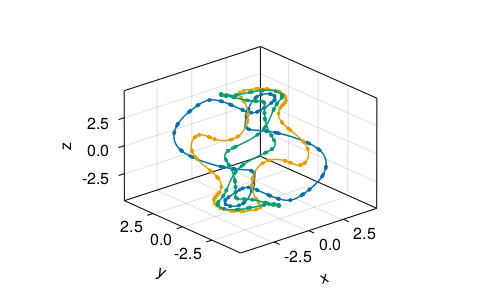

In [56]:
fig = Figure()
ax = Axis3(fig[1,1])
for (k, A) in attractors
    # Scatter the found points on the attractor by the recurrences algorithm
    scatter!(ax, vec(A); markersize = 5)
    # Also evolve an i.c. on the attractor and line plot it
    X, t = trajectory(thomas, 50.0, A[1])
    xt, yt, zt = columns(X)
    lines!(ax, xt, yt, zt)
end
fig

## `AttractorsViaFeaturizing`

This is an alternative way to find "attractors", which works as follows:

1. Initial conditions are evolved to generate trajectories.
2. Trajectories are mapped into "features": descriptive numbers of the trajectories that hopefully characterize different attractors differently. E.g., mean and std. of the first two  variables for a four-dimensional system.
3. Features are grouped using one of many choices, such as a clustering algorithm.
4. The created groups then correspond to unique "attractors".



Often it is not obvious what features would be good to separate the attractors, which is why we recommend the recurrences method when we know very little about the system.

In any case, for the Thomas cyclical example we have estimated in advance a featurizer that works well:

In [57]:
using Statistics: mean, std

function featurizer(A, t) # take in trajectory and time vector
    x, y, z = columns(A)
    mx = mean(x)
    sx = std(y)
    cz = std(y .- z)
    return SVector(mx, sx, cz) # return feature, preferably as static vector
end

featurizer (generic function with 1 method)

We also choose how to group features together. In this example, we will use a black box clustering algorithm called DBSCAN.

In [58]:
grouping_config = GroupViaClustering();

We now put everything together in `AttractorsViaFeaturizing` and get the fractions of the basins of attraction:

In [59]:
mapperf = AttractorsViaFeaturizing(
    thomas, featurizer, grouping_config;
    Ttr = 100.0, T = 100.0, Δt = 0.5
)

fs = basins_fractions(
    mapperf, sampler;
    show_progress = false
)

Dict{Int64, Float64} with 3 entries:
  2 => 0.347
  3 => 0.331
  1 => 0.322

To illustrate what the algorithm did, we'll write some code that is internally used by `AttractorsViaFeaturizing`:

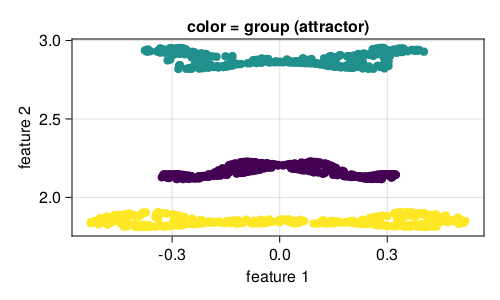

In [60]:
N = 1000
all_features = StateSpaceSet{3, Float64}()
for _ in 1:N
    u0 = sampler()
    A, t = trajectory(thomas, 100.0, u0; Ttr = 100.0, Δt = 0.5)
    feature = featurizer(A, t)
    push!(all_features, feature)
end

labels = group_features(all_features, grouping_config)

c1, c2 = columns(all_features)
scatter(c1, c2; color = labels, axis = (xlabel = "feature 1", ylabel = "feature 2", title = "color = group (attractor)"))

# Continuation of attractors and their basins fractions

Continuation in the context of Attractors.jl is done using the `continuation` function, so let's read its documentation string:

In [61]:
@doc continuation

```
continuation(abc::AttractorsBasinsContinuation, prange, pidx, ics; kwargs...)
```

Find and continue attractors (or feature-based representations of attractors) and the fractions of their basins of attraction across a parameter range. `continuation` is the central function of the framework for global stability analysis illustrated in [Datseris2023](@cite).

The continuation type `abc` is a subtype of `AttractorsBasinsContinuation` and contains an [`AttractorMapper`](@ref). The mapper contains information on how to find the attractors and basins of a dynamical system. Additional arguments and keyword arguments given when creating `abc` further tune the continuation and how attractors are matched across different parameter values.

The basin fractions and the attractors (or some representation of them) are continued across the parameter range `prange`, for the parameter of the system with index `pidx` (any index valid in [`set_parameter!`](@ref) can be used).

`ics` is a 0-argument function generating initial conditions for the dynamical system (as in [`basins_fractions`](@ref)).

Possible subtypes of `AttractorsBasinsContinuation` are:

  * [`RecurrencesFindAndMatch`](@ref)
  * [`FeaturizeGroupAcrossParameter`](@ref)

## Return

1. `fractions_curves::Vector{Dict{Int, Float64}}`. The fractions of basins of attraction. `fractions_curves[i]` is a dictionary mapping attractor IDs to their basin fraction at the `i`-th parameter.
2. `attractors_info::Vector{Dict{Int, <:Any}}`. Information about the attractors. `attractors_info[i]` is a dictionary mapping attractor ID to information about the attractor at the `i`-th parameter. The type of information stored depends on the chosen continuation type.

## Keyword arguments

  * `show_progress = true`: display a progress bar of the computation.
  * `samples_per_parameter = 100`: amount of initial conditions sampled at each parameter from `ics`.


`continuation` provides several methods for finding and continuing attractors, and also defines an extendable interface for adding future methods. Here we will focus on the Recurrences Find and Match (RAFM). 

Applying this method to the cyclical Thomas system we analyzed in the previous section is not interesting, because due to system symmetry the basins fractions are constantly 1/3 each. Instead, let's try to find, and continue, the attractors and the basins of attraction of the model from:

> Synthetic multistability in mammalian cells, Zhu et al., Science 375 (2022), DOI: 10.1126/science.abg9765

which is a modeing attempt at cells that may differentiate their behavior based on ongoing biological processes.

$$
\dot{A_i} = \alpha + \beta \frac{ B_i^n }{ 1 + B_i^n } - A_i, \quad i = 1, \ldots, N, 
$$

with

$$
B_i = \frac{2A_i^2}{ K_d + 4\sum A_i  + \sqrt{ K_d^2 + 8\sum A_i + K_d } }
$$

Here we will use $N=3$, which makes a 3-dimensional continuous time system. The starting parameters will be `α=4, β=20, n=1.5, Kd=80.0`. We are interested in the behavior of the model versions the `Kd` parameter. 

For the recurrences algorithm we do not need much accuracy for this particular system. The state space tesselation will therefore be from 0 to 100 for each dimension, divided into 100 cells.

In [62]:
# Define dynamical system
using OrdinaryDiffEq: Vern9
function cell_differentiation(N = 3, u0 = rand(N); α=4, β=20, n=1.5, Kd=1.0)
    p = [Kd, α, β, n]
    diffeq = (alg = Vern9(), reltol = 1e-9, abstol = 1e-9)
    ds = CoupledODEs(cell_differentiation_rule!, u0, p; diffeq)
    return ds
end
function cell_differentiation_rule!(du, u, p, t)
    Kd, α, β, n = p
    sum_u = sum(u)
    @inbounds for i ∈ eachindex(du)
        C = (2*u[i]^2) / (Kd + 4*sum_u + sqrt( Kd^2 + 8*sum_u*Kd )  )
        du[i] = α + (β*C^n)/(1+C^n) - u[i]
    end
    return nothing
end

ds = cell_differentiation(3)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      true
 dynamic rule:  cell_differentiation_rule!
 ODE solver:    Vern9
 ODE kwargs:    (reltol = 1.0e-9, abstol = 1.0e-9)
 parameters:    [1.0, 4.0, 20.0, 1.5]
 time:          0.0
 state:         [0.45530914227753405, 0.1757875064231179, 0.7682172478225997]


We then create an `AttractorsViaRecurrences` instance

In [63]:
grid_cell = ntuple(i -> range(0, 100; length=101), 3)

mapper = AttractorsViaRecurrences(
    ds, grid_cell; maximum_iterations = Int(1e9)
)

AttractorsViaRecurrences
 rule f:      AttractorsViaRecurrences
 system:      CoupledODEs
 grid:        Attractors.RegularGrid{3, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}([1.0, 1.0, 1.0], [0.0, 0.0, 0.0], [100.0, 100.0, 100.0], (0.0:1.0:100.0, 0.0:1.0:100.0, 0.0:1.0:100.0))
 attractors:  Dict{Int64, StateSpaceSet{3, Float64}}()


And now the only thing we need to do to continue these attractors across a parameter range is to initialize a `RecurrencesFindAndMatch` instance with the `mapper`, and give it to the `continuation` function!

In [64]:
sampler, = statespace_sampler(grid_cell)

(StateSpaceSets.RectangleGenerator{Float64, SVector{3, Float64}, Random.Xoshiro}([0.0, 0.0, 0.0], [100.0, 100.0, 100.0], [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], Random.Xoshiro(0x2b56a5d54b56fe2e, 0x9903ef9dd2ad3f6a, 0x94bb1b575d833015, 0xeb1dccd82cf34820)), StateSpaceSets.var"#isinside#54"{SVector{3, Float64}, SVector{3, Float64}}([100.0, 100.0, 100.0], [0.0, 0.0, 0.0]))

In [65]:
rsc = RecurrencesFindAndMatch(mapper; threshold = Inf)

pidx = 1 # index of parameter to change (here Kd)
prange = range(1e-2, 1e2; length = 101) # parameter range to scan

@time fractions_curves, attractors_info = continuation(
    rsc, prange, pidx, sampler;
    show_progress = false, samples_per_parameter = 1000
)
fractions_curves

  8.992723 seconds (7.18 M allocations: 554.844 MiB, 2.05% gc time, 16.74% compilation time: 100% of which was recompilation)


101-element Vector{Dict{Int64, Float64}}:
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 Dict(1 => 1.0)
 ⋮
 Dict(5 => 0.33664349553128103, 6 => 0.3535253227408143, 7 => 0.3028798411122145, 1 => 0.006951340615690168)
 Dict(5 => 0.33266932270916333, 6 => 0.35756972111553786, 7 => 0.2958167330677291, 1 => 0.013944223107569721)
 Dict(5 => 0.34760956175298807, 6 => 0.3336653386454183, 7 => 0.29780876494023906, 1 => 0.02091633466135458)
 Dict(5 => 0.33167330677290835, 6 => 0.3197211155378486, 7 => 0.3256972111553785, 1 => 0.022908366533864542)
 Dict(1 => 0.03386454183266932, 5 => 0.3296812749003984, 6 => 0.30776892430278885, 7 => 0.3286852589641434)
 Dict(5 => 0.3197211155378486, 6 => 0.32768924302788843, 7 => 0.31274900398406374, 1 => 0.0398406374501992)
 Dict(5 => 0.29780876494023906, 6 => 0.29880478087649404, 7 => 0.3047808764940239, 1 => 0.09860557768924302)
 Dict(5 => 0.3047808764940239, 6 

Let's now plot the results we found using one of the provided plotting functions from Attractors.jl:

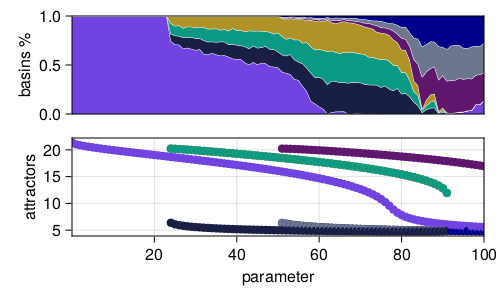

In [66]:
# Decide how to plot attractors: go from attractor to real number
attractor_to_real = A -> maximum(x[1] for x in A)

plot_basins_attractors_curves(fractions_curves, attractors_info, attractor_to_real, prange)

## Matching attractors

Advanced. Do we have time...?

## Sidenote: local bifurcation & continuation

In our opinion, the approach of Attractors.jl supercedes the decades-old approach  used in nonlinear dynamics that is the local bifurcation & continuation method on the basis of Newton's algorithm (and more advanced variants). That is, we believe that a practitioner is better off using Attractors.jl most of the time, and only turning to the old approach when e.g., interested in unstable sets, or an automated analysis of structural change of the Jacobian eigenvalues (i.e., a local bifurcation). Traditional continuation analysis in Julia can be done with BifurcationKit.jl, which is not taught as part of these lectures.

# Other measures of global stability

By default, `continuation` continues the attractors and their basin fractions. The basin fractions is the most basic measure of **global stability** (also known as **non-local stability** or **resilience**). But there are other ways to quantify global stability, some of which are also available out of the box.

Another typical measure of global stability is the **minimal fatal shock** (MFS), that is, the perturbation of least mangitude we need to do on a state to push the state into a basin of another attractor. In Attractors.jl the function `minimal_fatal_shock` computes this quantity for _any_ dynamical system. This is a huge improvement over the paper that originally introduced the concept, as there it was only possible to compute for a very specific class of dynamical systems.

The way `minimal_fatal_shock` works is very simple. Give in a dynamical system, a state `u0`, and an algorithm specification for how to find the MFS. Then the function will return the MFS. Let's use this at the cell differention model. We first find all its attractors, and then we find the MFS correpsonding to each attractor.

In [70]:
cell = cell_differentiation(3)
set_parameter!(ds, 1, 80.0)
mapper_cell = AttractorsViaRecurrences(ds, grid_cell)
sampler_cell, = statespace_sampler(grid_cell, 12345)
fractions = basins_fractions(mapper_cell, sampler_cell; show_progress = false)
attractors = extract_attractors(mapper_cell)

Dict{Int64, StateSpaceSet{3, Float64}} with 6 entries:
  5 => 3-dimensional StateSpaceSet{Float64} with 1 points
  4 => 3-dimensional StateSpaceSet{Float64} with 1 points
  6 => 3-dimensional StateSpaceSet{Float64} with 1 points
  2 => 3-dimensional StateSpaceSet{Float64} with 1 points
  3 => 3-dimensional StateSpaceSet{Float64} with 1 points
  1 => 3-dimensional StateSpaceSet{Float64} with 1 points

Obtain the MFS for each attractor

In [72]:
search_area = (1.0, 100.0)
mfs_algo = MFSBruteForce(1000, 2000, 0.995) # black box optimization is an alternative
@time shocks = Dict(
    i => minimal_fatal_shock(mapper_cell, A[1], search_area, mfs_algo)
    for (i, A) in attractors
)

  1.285481 seconds (786.91 k allocations: 64.351 MiB, 2.19% gc time, 5.43% compilation time)


Dict{Int64, Vector{Float64}} with 6 entries:
  5 => [-0.294855, 7.63292, -3.01436]
  4 => [7.77394, -2.16977, -1.54287]
  6 => [-2.71006, -0.885144, 7.68853]
  2 => [0.404509, 0.943913, -2.50424]
  3 => [0.809183, 0.398112, -2.54453]
  1 => [-2.5375, 0.897014, 0.227925]

In [73]:
using LinearAlgebra: norm
shock_magnitudes = Dict(i => norm(s) for (i, s) in shocks)

Dict{Int64, Float64} with 6 entries:
  5 => 8.21186
  4 => 8.21721
  6 => 8.20008
  2 => 2.70663
  3 => 2.69962
  1 => 2.70102

# Exercises

## Basins of attraction of a fast-slow multistable model

The goal of this exercise is to demonstrate that `AttractorsViaRecurrences` is not magic, and has its own limitations. 

Consider the following (modified) form of the Rozenweig-MacArthur continuous time model for predator-prey dynamics:
$$

\begin{align}
\frac{dN}{dt} & = rN\left(1-\frac{c}{r}N\right)\left(\frac{N-\mu}{N+\nu}\right) - A \\
\frac{dP}{dt} & = \chi A - \delta P \\
A & = \frac{\alpha N P}{\beta + N} 
\end{align}
$$

with initial parameters `p = [2.0, 0.19, 0.03, 0.003, 800, 1.5, 0.004, 2.2] = r, c, μ, ν, α, β, χ, δ`. 

After creating the dynamical system instance, create a `AttractorViaRecurrences` instance, using the following grid. Set your own choice for `consecutive_recurrences`, which is the keyword that decides how many recurrences we should count before declaring convergence to an attractor.

```julia
density = 101
xg = range(-0.1, 20; length = density)
yg = range(-0.0001, 0.03; length = density)
grid = (xg, yg)

mapper = AttractorsViaRecurrences(
    ds, grid;
    consecutive_recurrences = YOUR_CHOICE, Δt = 0.01,
)
```

Then, use the function `basins_of_attraction` to estimate the basins of attraction.
For estimating the basins, avoid initial conditions with ≤ 0 values, i.e., use 
```julia
basinsgrid = (xg[2:end], yg[2:end])
basins, attractors = basins_of_attraction(mapper, basinsgrid)
```
You may visualize these results using 
```julia
fig = heatmap_basins_attractors(basinsgrid, basins, attractors)
```

Repeat this calculation while varying `consecutive_recurrences`. You will notice that for low values of `consecutive_recurrences` the computation fails with an informative error. Can you understand why? Use the `interactive_evolution` application of DynamicalSystems.jl and evolve some initial conditions to help you comprehend the problem.

## Continuation of basins fractions and Hopf bifurcation identification

Continue from the previous exercise. To ensure accurate attractor identification, use the following keywords for `AttractorsViaRecurrences`
```julia
consecutive_recurrences = 5000, Δt = 0.1,
force_non_adaptive = true, Ttr = 100.0,
```
Use the `continuation` function to continue attractors and their fractions across the parameter range `r = 1` to `2`. Use the `statespace_sampler` function to generate random initial conditions in the `basinsgrid` you defined above. Plot the fractions of basins of attraction versus the parameter range, and the attractor value, using the following function to map attractors to real numbers:
```julia
using Statistics: mean
attractor_to_real = A -> mean(x[1] for x in A)
```

The solution of the exercise should be that you have only two attractors and the fractions of their basins are approximately 50% all the time.

One of the two attractors is a fixed point that becomes a limit cycle, i.e., it undergoes a Hopf bifurcation. Find the parameter value where this occurs by analyzing the attractors corresponding to the ID of the "fixed point -> limit cycle" attractor. Identify the bifurcation point by checking when then `length` of the attractor becomes larger than 1. (this means, the attractor spans more than 1 cells in the tesselated state space)

## Minimal fatal shock for generic attractors

The minimal fatal shock (MFS) concept was originally defined for fixed point attractors. For limit cycles or chaotic attractors the concept is less useful as there is no specific state on the attractor from which it is the most relevant to obtain the MFS. In such cases one would have to obtain MFSs for many points on the attractor. This exercise is about doing exactly that!

Continue from the above definition of the Thomas cyclical system with parameter `b = 0.16`. Obtain any of the three attractors of the system by doing `id = mapper([1, 2, 3.0])`, and then `A = extract_attractors(mapper)[id]`. Calculate the MFS for various states on the attractor `A` and collect all these MFSs in a vector. What is the average shock magnitude? Plot a scatter plot of the shock mangitude on the attractor (i.e., scatterplot the points of `A` while assigning as color the mangitude of the corresponding MFS).
